In [1]:
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [2]:
raw_data = pd.read_csv("IPL_Ball_by_Ball_2008_2022.csv")
raw_data = raw_data.sample(frac=0.05, random_state=42)
raw_data

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
177814,501226,1,12,2,MS Dhoni,Yuvraj Singh,MEK Hussey,NaN,1,0,1,0,0,NaN,NaN,NaN,Chennai Super Kings
3287,1304107,1,17,4,SW Billings,T Natarajan,AD Russell,NaN,6,0,6,0,0,NaN,NaN,NaN,Kolkata Knight Riders
188612,419148,2,13,3,RV Uthappa,AD Mathews,LRPL Taylor,NaN,0,0,0,0,0,NaN,NaN,NaN,Royal Challengers Bangalore
96212,980961,1,13,6,RA Jadeja,Z Khan,KD Karthik,NaN,0,0,0,0,0,NaN,NaN,NaN,Gujarat Lions
30637,1254064,1,5,1,RR Pant,JD Unadkat,AM Rahane,NaN,4,0,4,0,0,NaN,NaN,NaN,Delhi Capitals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88896,1082592,1,5,5,JC Buttler,DL Chahar,RG Sharma,NaN,6,0,6,0,0,NaN,NaN,NaN,Mumbai Indians
52430,1178412,2,13,1,SS Iyer,GC Viljoen,S Dhawan,NaN,1,0,1,0,0,NaN,NaN,NaN,Delhi Capitals
36036,1216536,1,6,1,Shubman Gill,RA Jadeja,N Rana,NaN,1,0,1,0,0,NaN,NaN,NaN,Kolkata Knight Riders
16593,1304052,2,5,2,SE Rutherford,AD Russell,DJ Willey,NaN,0,0,0,0,0,NaN,NaN,NaN,Royal Challengers Bangalore


In [3]:
def over_data(raw_data):
    
    raw_data=raw_data[raw_data['total_run']<=6] # Outliers
    
    over_info = pd.DataFrame()
    
    over_info['overid'] = raw_data['ID']*40+(raw_data['innings']-1)*20+raw_data['overs'] # Unique ID for over
    over_info['type'] = (raw_data['overs']>6).astype(int) + (raw_data['overs']>15).astype(int) # Powerplay/Middle/Death
    
    # Batter Columns
    distinct_batters = raw_data['batter'].unique()
    batter_names = pd.concat([(raw_data['batter'].fillna('').isin([batter]) | raw_data['non-striker'].fillna('').isin([batter])).astype(int) for batter in distinct_batters], axis=1)
    batter_names.columns = distinct_batters
    over_info = pd.concat([over_info,batter_names],axis=1)

    # Bowler Columns
    distinct_bowlers = raw_data['bowler'].unique()
    bowler_names = pd.concat([raw_data['bowler'].fillna('') == bowler for bowler in distinct_bowlers], axis=1).astype(int)
    bowler_names.columns = distinct_bowlers
    over_info = pd.concat([over_info,bowler_names],axis=1)
    
    over_info['total_run'] = raw_data['total_run'] 
    over_info['total_wickets'] = raw_data['isWicketDelivery']
    
    # Grouping each over's information
    over_info = over_info.groupby(over_info['overid']).sum()
    for batter in distinct_batters :
        over_info[batter] = (over_info[batter]>0).astype(int)
    for bowler in distinct_bowlers :
        over_info[bowler]=(over_info[bowler]>0).astype(int)
    
    return over_info

In [4]:
modified_data = over_data(raw_data)
modified_data

,type,MS Dhoni,SW Billings,RV Uthappa,RA Jadeja,RR Pant,KL Rahul,YK Pathan,E Lewis,TM Dilshan,...,P Ray Barman,SR Tendulkar,Mandeep Singh,AS Roy,LRPL Taylor,K Yadav,AM Rahane,NB Singh,total_run,total_wickets
overid,,,,,,,,,,,,,,,,,,,,,
13439280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13439282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13439285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13439287,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13439288,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52488020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52488021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52488030,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [5]:
X = modified_data.drop(columns = ["total_run","total_wickets"])
Y = modified_data["total_run"]
pca = PCA(n_components=50) 
X = pca.fit_transform(X)   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1092003)

In [6]:
def MLPRegression(X_train,Y_train):
    regressor = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10000000, random_state=42)
    regressor.fit(X_train, Y_train)
    return regressor

In [7]:
print("Using MLP Regression :-")
model_MLPregression = MLPRegression(X_train,Y_train)
Y_train_pred = model_MLPregression.predict(X_train)
Y_test_pred = model_MLPregression.predict(X_test)

Using MLP Regression :-


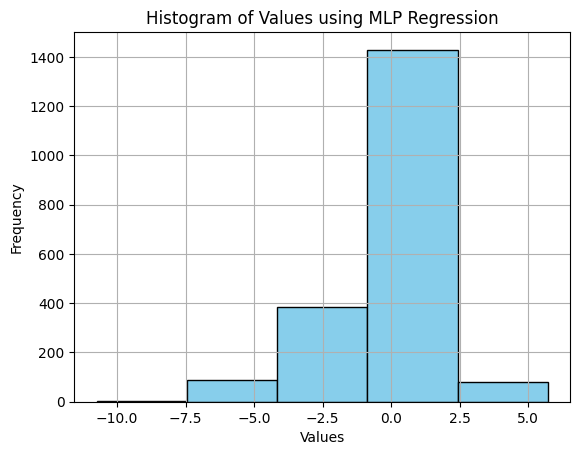

10.730319067800375

In [8]:
MLPegression_list = []
max_error = 0
for _ in range(len(Y_test)):
    MLPegression_list.append(Y_test_pred[_]-Y_test.iloc[_])
    max_error = max(max_error,abs(Y_test_pred[_]-Y_test.iloc[_]))
# Creating a histogram
plt.hist(MLPegression_list, bins=5, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values using MLP Regression')
plt.grid(True)
plt.show()
max_error

In [9]:
avg = np.mean(MLPegression_list)
var = np.var(MLPegression_list)

print("Average:", avg)
print("Variance:", var)

Average: -0.044911418976547324
Variance: 3.730610234841743
